## Load raw waveforms from binary file

In this notebook, we will load raw waveforms  from a binary file and plot them according to channel locations.

TODO: compute amplitudes of waveforms

In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import spks.io as sio
from spks.raw import RawRecording

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
DATADIR = 'V:/Subjects/MM008/'
PROBE_INDEX = 0
SESSION_INDEX = 0
#spikesorting_folders = sio.list_kilosort_result_paths(DATADIR)[PROBE_INDEX]
KILOSORT_FOLDER = r'V:/Subjects/MM012/2023-08-11/001/spike_sorters/pykilosort/probe00'
#COMPRESSED_BINARY_FILE = r'V:/Subjects/MM012/2023-08-11/001/raw_ephys_data/probe00/_spikeglx_ephysData_g0_t0.imec0.ap.cbin' 
COMPRESSED_BINARY_FILE = r'X:/test_ephys_session/_spikeglx_ephysData_g0_t0.imec0.ap.bin' #decompressed

### Get the spike times and clusters from putative single units
We will use the Kilosort labels here, but this can also be done after phy curation

In [11]:
raw_recording = RawRecording([COMPRESSED_BINARY_FILE], return_preprocessed=False) #TODO: make this handle .cbin files. Turn on preprocessing?
clusters = sio.load_cluster_data(KILOSORT_FOLDER)
print(clusters.keys())

cluster_labels = clusters['labels'].KSLabel.values
cluster_ids = clusters['labels'].cluster_id.values
good_cluster_ids = cluster_ids[np.where(cluster_labels == 'good')]
#print(good_cluster_ids)

good_spikes = clusters['spks'][np.isin(clusters['clusters'],good_cluster_ids)] 
good_clusters = clusters['clusters'][np.isin(clusters['clusters'],good_cluster_ids)]  

assert good_spikes.shape == good_clusters.shape

Using kilosort data (either there is no phy curation, or the user has specified that kilosort data should be used).
dict_keys(['spks', 'clusters', 'labels'])


### Extract all waveforms from the binary

In [12]:
CLUSTER_ID = 111
good_spikes = good_spikes[good_clusters == CLUSTER_ID] # only get spikes from one cluster
print(f'We will extract {len(good_spikes)} spikes for this cluster')

#good_spikes = np.hstack((good_spikes + 30000, good_spikes + np.max(good_spikes) - 30000))
print(good_spikes.shape)

We will extract 34074 spikes for this cluster
(34074,)


In [13]:
import spks.waveforms as spwaves

SCRATCH_DIR = 'C:/Data/churchland' # fast disk to write memmap file
nchannels = raw_recording.shape[1]

waves = spwaves.extract_memmapped_waveforms(raw_recording, SCRATCH_DIR, good_spikes[:100])
waves.shape # (nspikes, nsamples, nchannels)

Extracting waveforms with chunk-size 10


Extracting waveforms: 100%|██████████| 10/10 [00:00<00:00, 714.26it/s]


(100, 60, 385)

### Compute mean waveforms with 1000 spikes from each cluster

In [14]:
from spks.phy_utils import read_phy_data
from spks.waveforms import extract_waveform_set

spike_times = read_phy_data(KILOSORT_FOLDER, srate=1, use_kilosort_results=True)['ts']

waves = extract_waveform_set(spike_times, raw_recording, max_n_spikes=100)
waves = extract_waveform_set(spike_times, raw_recording, max_n_spikes=100, mmap_output=True, scratch_directory=SCRATCH_DIR)

This session has not been curated or user has forced use of kilosort results. Labels are from KS.


100%|██████████| 1702/1702 [00:42<00:00, 40.44it/s]


(383, 2)


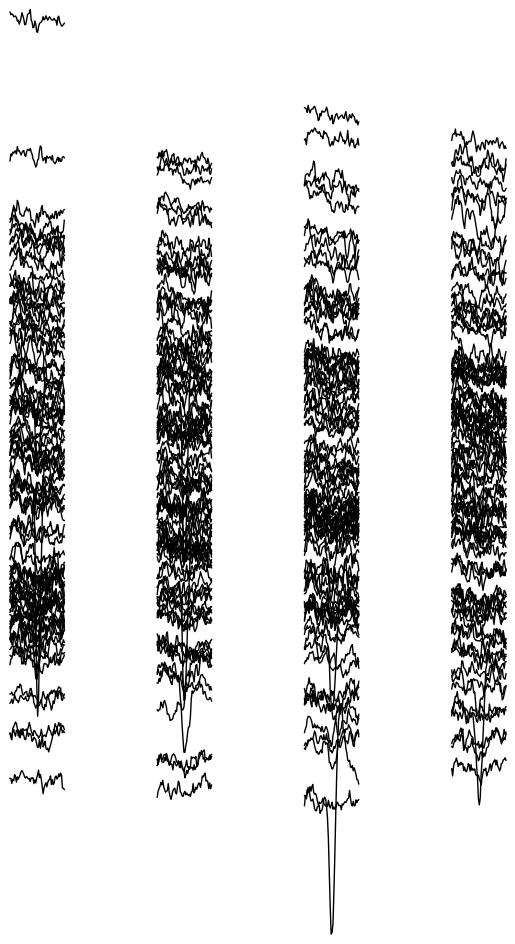

In [15]:
from spks.viz import plot_footprints

CLUSTER_IND = 111

channel_xy = raw_recording.metadata[0]['coords']
channel_idx = raw_recording.metadata[0]['channel_idx']
print(channel_xy.shape)
plot_footprints(np.mean(waves[CLUSTER_IND][:,:,channel_idx], axis=0), channel_xy)
plt.show()

del waves #deletes the temporary bin files